# $\pi/2$ rotation in the $xy$ plane

In [2]:
%load_ext autoreload
%autoreload 2
import site
import sys
site.addsitedir('..')

In [3]:
import numpy as np
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate
from src.interpolate import *

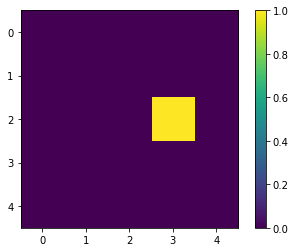

In [4]:
nx = 5
shape = np.array([nx, nx, nx])
dimensions = np.array([1, 1, 1])
radius = 1/(2*nx)
centre = np.array([0.2,0,0])
intensity = 1

v = spherical_volume(shape, dimensions, centre, radius, intensity, False)
plt.imshow(v[:,:,2]); plt.colorbar()

angles = np.array([0,0,-np.pi/2])

In [227]:
point_idx = np.array(list(np.where(v == 1))).flatten()

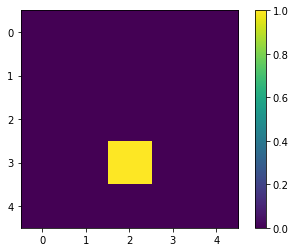

In [228]:
v_proj = project_spatial(v, angles, dimensions, "tri")

plt.imshow(v_proj); plt.colorbar()

In [229]:
point_idx = np.array(list(np.where(v == 1))).flatten()

### Step by step inside the project function

In [230]:
nx = 5
shape = np.array([nx, nx, nx])
dimensions = np.array([1, 1, 1])
radius = 1/(2*nx)
centre = np.array([0.2,0,0])
intensity = 1

v = spherical_volume(shape, dimensions, centre, radius, intensity, False)

v = np.fft.ifftshift(v)

V, X, Y, Z, _, _, _ = volume_fourier(v, dimensions)

angles = np.array([0,0,-np.pi/2])

#plt.imshow(v[:,:,0]); plt.colorbar()

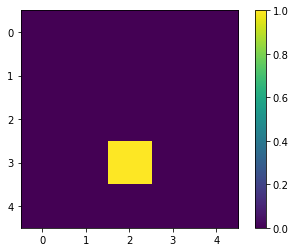

In [231]:
# Rotate coordinates

Xr, Yr, Zr = rotate(X, Y, Z, angles)
slice_coords = np.array([Xr[:,:,0].flatten(),Yr[:,:,0].flatten(),Zr[:,:,0].flatten()])

# Get x_freq, etc
x_freq = X[0,:,0]
y_freq = Y[:,0,0]
z_freq = Z[0,0,:]

# Interpolate and reshape
Vr0_flat = interpolate(slice_coords, x_freq, y_freq, z_freq, V, "tri")
Vr0 = Vr0_flat.reshape(5,5)

# Inverse Fourier transform
vr0 = np.real(np.fft.fftshift(np.fft.ifftn(Vr0)))
plt.imshow(vr0)
plt.colorbar()

In [232]:
# Compare with the above approach
np.sum(abs(vr0 - v_proj))

0.0

## Analytically

In [233]:
Ky = np.array([[0,0,0,0,0],[1,1,1,1,1],[2,2,2,2,2],[-2,-2,-2,-2,-2],[-1,-1,-1,-1,-1]])
Kx = Ky.T

In [234]:
# Negate the angle since the object rotates in the opposite direction 
# to the coordinate axes
gamma = np.pi/2

R = np.array([[np.cos(gamma), -np.sin(gamma)],
            [np.sin(gamma), np.cos(gamma)]])

rc = []
for x, y in zip(Kx.flatten(), Ky.flatten()):
    xy2 = R @ np.array([x,y])
    rc.append(list(xy2))

rc = np.array(rc)  

Kxr = rc[:,0].reshape(Kx.shape)
Kyr = rc[:,1].reshape(Ky.shape)



In [235]:
print(Kx)
print(Kxr)

[[ 0  1  2 -2 -1]
 [ 0  1  2 -2 -1]
 [ 0  1  2 -2 -1]
 [ 0  1  2 -2 -1]
 [ 0  1  2 -2 -1]]
[[ 0.0000000e+00  6.1232340e-17  1.2246468e-16 -1.2246468e-16
  -6.1232340e-17]
 [-1.0000000e+00 -1.0000000e+00 -1.0000000e+00 -1.0000000e+00
  -1.0000000e+00]
 [-2.0000000e+00 -2.0000000e+00 -2.0000000e+00 -2.0000000e+00
  -2.0000000e+00]
 [ 2.0000000e+00  2.0000000e+00  2.0000000e+00  2.0000000e+00
   2.0000000e+00]
 [ 1.0000000e+00  1.0000000e+00  1.0000000e+00  1.0000000e+00
   1.0000000e+00]]


In [236]:
print(Ky)
print(Kyr)

[[ 0  0  0  0  0]
 [ 1  1  1  1  1]
 [ 2  2  2  2  2]
 [-2 -2 -2 -2 -2]
 [-1 -1 -1 -1 -1]]
[[ 0.0000000e+00  1.0000000e+00  2.0000000e+00 -2.0000000e+00
  -1.0000000e+00]
 [ 6.1232340e-17  1.0000000e+00  2.0000000e+00 -2.0000000e+00
  -1.0000000e+00]
 [ 1.2246468e-16  1.0000000e+00  2.0000000e+00 -2.0000000e+00
  -1.0000000e+00]
 [-1.2246468e-16  1.0000000e+00  2.0000000e+00 -2.0000000e+00
  -1.0000000e+00]
 [-6.1232340e-17  1.0000000e+00  2.0000000e+00 -2.0000000e+00
  -1.0000000e+00]]


In [237]:
# Find the indices (3,2) of the point mass after ifftshift (in the spatial domain)
xy_freq = np.array([0, 1, 2, -2, -1])
new_idx1 = np.fft.fftshift(xy_freq)[point_idx[0]]
new_idx2 = np.fft.fftshift(xy_freq)[point_idx[1]]

print(new_idx1)
print(new_idx2)

0
1


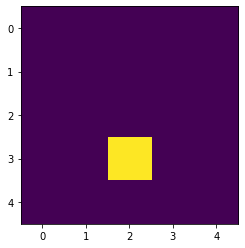

In [238]:
vr0_a = np.zeros([5,5], dtype = np.complex128)
for i in range(5):
    for j in range(5):
        vr0_a[i,j] = 1/25 * np.sum(
            np.exp(1j * 2 * np.pi/5* 
                # When ifftshifted, the indices (2, 3) become (0, 1)
                (i * Kx + j * Ky - new_idx1 * Kxr - new_idx2 * Kyr) 
            )
        )

vr0_a = np.real(np.fft.fftshift(vr0_a))
plt.imshow(vr0_a)

In [239]:
# Compare with the numerical result
np.max(abs(vr0_a - vr0))

1.509903313490213e-16